In [1]:
import os
import numpy as np
import numpy.random  as rd
import scipy as sp
from scipy import stats as st
from collections import Counter
import pandas as pd

import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
import matplotlib.animation as ani
import random
import math
plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]
%matplotlib inline

In [2]:
df = pd.read_csv("../../../DL/finance/data/1d/nikkei225_d.csv")

In [3]:
df.Date = [i.replace("/", "-")for i in df.Date]
df.head()

,Date,Open,High,Low,Close
0,1986-01-04,13118.50,13142.33,13105.97,13136.87
1,1986-01-06,13129.05,13145.54,13053.22,13053.79
2,1986-01-07,13034.57,13037.68,12933.50,12991.24
3,1986-01-08,12997.74,13057.46,12996.80,13056.42
4,1986-01-09,13036.08,13062.26,12959.21,13034.19


In [4]:
df["Date"] = pd.DatetimeIndex(df["Date"])
df["day_of_week"] = df.Date.dt.dayofweek
df = df.iloc[3540:]
df.iloc[:, 1:-1] = (df.iloc[:, 1:-1]-df.iloc[:, 1:-1].min())/(df.iloc[:, 1:-1].max() - df.iloc[:, 1:-1].min())
df.head()

,Date,Open,High,Low,Close,day_of_week
3540,2000-01-04,0.856924,0.872574,0.862694,0.864970,1
3541,2000-01-05,0.861690,0.859283,0.810999,0.831646,2
3542,2000-01-06,0.830704,0.828907,0.807131,0.804550,3
3543,2000-01-07,0.803291,0.807465,0.799895,0.806370,4
3544,2000-01-11,0.807046,0.850913,0.812753,0.853971,1


In [5]:
os.chdir("..")
home_dir = os.getcwd()
os.chdir("src")
from sdle import SDLE
from sdem import SDEM
os.chdir(home_dir)

In [6]:
x = df.day_of_week.reshape((df.shape[0], 1))
y = df.Close.reshape((df.shape[0], 1))
#Z = np.concatenate([x, y], axis=1)
Z = np.concatenate([x, df.iloc[:, 1:-1]], axis=1)

/Users/satetsu/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
/Users/satetsu/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


In [7]:
def hellinger_distance(mu, sigma, mu_prev, sigma_prev):
    mu = mu.reshape((mu.shape[0], 1))
    mu_prev = mu_prev.reshape((mu_prev.shape[0], 1))
    
    d_h = -(2*np.linalg.det((np.linalg.inv(sigma) + np.linalg.inv(sigma_prev))/2)**(-1/2))/(np.linalg.det(sigma)**(1/4)*np.linalg.det(sigma_prev)**(1/4))
    
    tmp = np.exp((1/2)*np.dot(np.dot(np.dot(np.linalg.inv(sigma), mu) + np.dot(np.linalg.inv(sigma_prev), mu_prev).T, 
                              np.linalg.inv(np.linalg.inv(sigma)+np.linalg.inv(sigma_prev))),
                              np.dot(np.linalg.inv(sigma), mu + np.dot(np.linalg.inv(sigma_prev), mu_prev).T)))
    d_h *= np.exp(-(1/2)*(np.dot(np.dot(mu.T, np.linalg.inv(sigma)), mu) + np.dot(np.dot(mu_prev.T, np.linalg.inv(sigma_prev)), mu_prev)))
    d_h += 2
    return d_h

def calc_hellinger_distance(pi, pi_prev, mu, sigma, mu_prev, sigma_prev, k):
    d_H = 0
    for i in range(k):
        d_h = hellinger_distance(mu[i], sigma[i], mu_prev[i], sigma_prev[i])
        d_H += (pi[i] + pi_prev[i])/2 * d_h
    tmp = 0
    for i in range(k):
        tmp += np.sqrt(pi[i]) - np.sqrt(pi_prev[i]) ** 2
    d_H += tmp 
    return d_H

def calc_hellinger_score(p, p_prev, sdem, r, k, M):
    S_H = 0
    for m in range(M):
        d_H = calc_hellinger_distance(sdem[m].pi[sdem[m].t-1], sdem[m].pi[sdem[m].t-2] ,sdem[m].mu[sdem[m].t-1],
                                      sdem[m].sigma[sdem[m].t-1], sdem[m].mu[sdem[m].t-2], sdem[m].sigma[sdem[m].t-2], k)
        S_H += np.sqrt(p[m] * p_prev[m]) * d_H
    tmp = 0
    for m in range(M):
        tmp += np.sqrt(p[m] * p_prev[m])
    tmp *= 2
    S_H += 2 - tmp
    S_H /= r**2
    
    return S_H

In [8]:
# パラメータ設定
alpha = 2.0
k = 3
T = Z.shape[0]
d = Z.shape[1]-1
r = 1/T
beta = 1
M = 5

In [9]:
# オブジェクトの初期化
sdle = SDLE(r, beta, M, T)
sdem = [SDEM(r, alpha, k, T, d) for i in range(M)]

# 同時確率
p = []
# ヘリンジャースコア
S_H = []
# 対数損失
S_L = []

for i, z in enumerate(Z):
    sdle.update(z[0])
    # 各セルに対応する混合ガウス分布を推定
    for m in range(sdle.M):
        if m == int(sdle.flag):
            sdem[m].update(z[1:])
        else:
            sdem[m].skip()
        # tmp: p(y|x)
        tmp = np.dot(sdem[m].prob[sdem[m].t-1],sdem[m].pi[sdem[m].t-1])
    if i == 0:
        p_prev = 0
    else:
        p_prev = p[-1]
    p_t = tmp * sdle.prob[sdle.t-1, int(sdle.flag)]
    p.append(p_t)
    s_h = calc_hellinger_score(sdle.prob[sdle.t-1], sdle.prob[sdle.t-2], sdem, sdle.r, k, sdle.M)
    S_H.append(float(s_h))
    s_l = -np.log(p_prev)
    S_L.append(s_l)

/Users/satetsu/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in log


In [10]:
df["S_L"] = np.array(S_L)
df["S_H"] = np.array(S_H)
df = df.iloc[1000:]
df.describe()

,Open,High,Low,Close,day_of_week,S_L,S_H
count,3173.000000,3173.000000,3173.000000,3173.000000,3173.000000,3173.000000,3.173000e+03
mean,0.445525,0.448842,0.444268,0.447206,2.039710,11.542968,3.482729e+07
std,0.249145,0.250399,0.248227,0.250052,1.401562,0.373662,5.737038e+02
min,0.000000,0.000000,0.000000,0.000000,0.000000,10.735372,3.482586e+07
25%,0.218426,0.218442,0.219481,0.219006,1.000000,11.291613,3.482712e+07
50%,0.431305,0.439582,0.428757,0.432788,2.000000,11.637024,3.482742e+07
75%,0.662859,0.667236,0.658068,0.662484,3.000000,11.780306,3.482769e+07
max,1.000000,1.000000,1.000000,1.000000,4.000000,12.429449,3.482816e+07


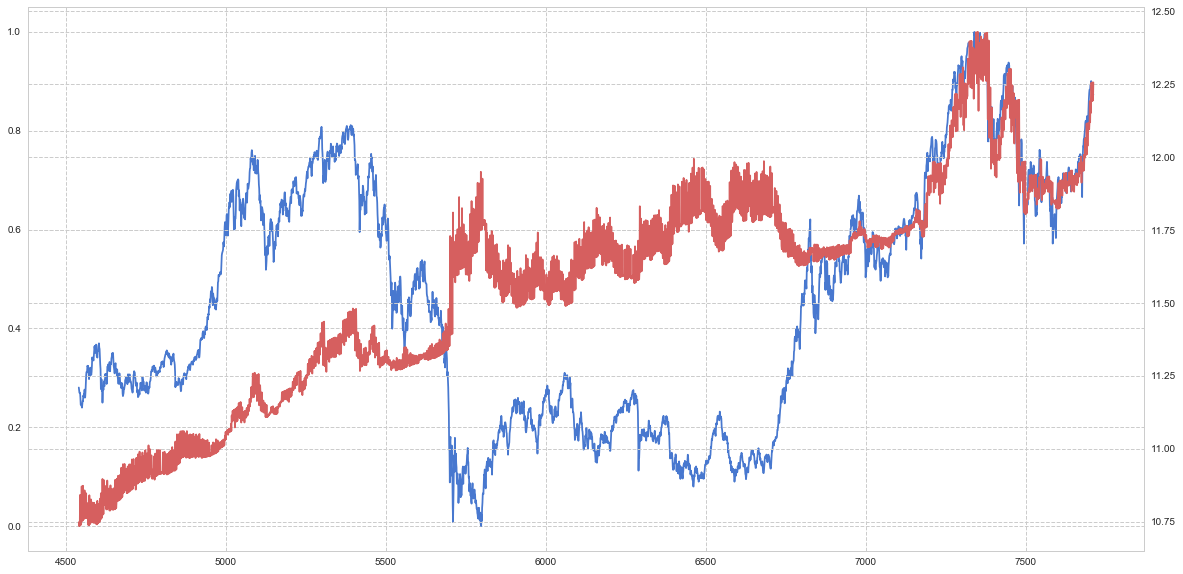

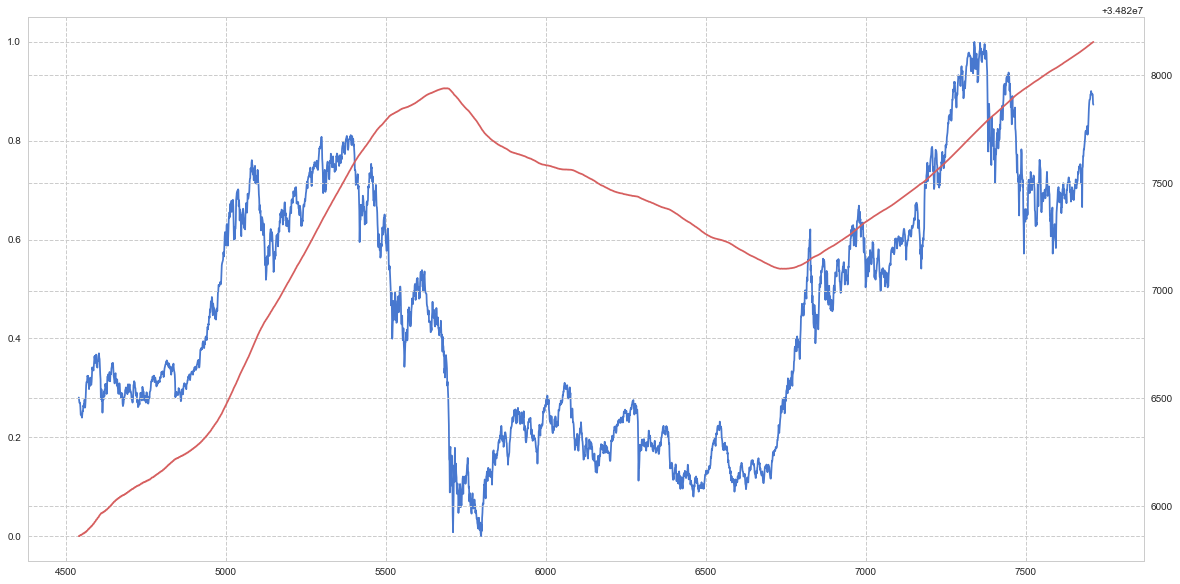

In [11]:
# data_uj: ret_n, data_n: ret_uj
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(df.Close)
ax2 = ax.twinx()
ax2.plot(df.S_L,'r')
plt.show()

# data_uj: ret_n, data_n: ret_uj
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(df.Close)
ax2 = ax.twinx()
ax2.plot(df.S_H,'r')
plt.show()

In [12]:
df.sort("S_L", axis=0, ascending=False)

/Users/satetsu/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Date,Open,High,Low,Close,day_of_week,S_L,S_H
7351,2015-07-09,0.891939,0.920790,0.875534,0.926698,3,12.429449,3.482775e+07
7349,2015-07-07,0.959139,0.962120,0.963806,0.964422,1,12.428472,3.482774e+07
7345,2015-07-01,0.954581,0.956254,0.955722,0.961000,2,12.428103,3.482774e+07
7380,2015-08-20,0.947598,0.949015,0.941854,0.939585,3,12.426166,3.482779e+07
7378,2015-08-18,0.979798,0.979098,0.978837,0.977300,1,12.425502,3.482779e+07
7347,2015-07-03,0.967974,0.971470,0.970602,0.976237,4,12.425026,3.482774e+07
7374,2015-08-12,0.979228,0.981987,0.961339,0.965593,2,12.424809,3.482778e+07
7376,2015-08-14,0.970980,0.974931,0.974461,0.974764,4,12.421794,3.482778e+07
7360,2015-07-23,0.983621,0.982350,0.986314,0.986673,3,12.413857,3.482776e+07
7370,2015-08-06,0.989046,0.990237,0.987447,0.985261,3,12.404046,3.482777e+07
